In [396]:
# To run this example, move this file to the main directory of this repository
from citylearn import  CityLearn
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import cvxpy as cp
import json
import time
from agents.rbc import RBC
from copy import deepcopy


import warnings
warnings.filterwarnings("ignore")

In [397]:
# Select the climate zone and load environment
climate_zone = 5
sim_period = (0, 8760*4-1)
params = {'data_path':Path("data/Climate_Zone_"+str(climate_zone)), 
        'building_attributes':'building_attributes.json', 
        'weather_file':'weather_data.csv', 
        'solar_profile':'solar_generation_1kW.csv', 
        'carbon_intensity':'carbon_intensity.csv',
        'building_ids':["Building_"+str(i) for i in [1,2,3,4,5,6,7,8,9]],
        'buildings_states_actions':'buildings_state_action_space.json', 
        'simulation_period': sim_period, 
        'cost_function': ['ramping','1-load_factor','average_daily_peak','peak_demand','net_electricity_consumption','carbon_emissions'], 
        'central_agent': False,
        'save_memory': False }

env = CityLearn(**params)

observations_spaces, actions_spaces = env.get_state_action_spaces()

## Load Data

In [398]:
def get_current_data(env, t):
    """ Returns data:dic for each building from `env` for `t` timestep """
    
    ### FB - Full batch. Trim output X[:time-step]
    ### CT - current timestep only. X = full_data[time-step], no access to full_data
    ### DP - dynamic update. time-step k = [... k], time-step k+n = [... k + n].
    ### P - constant value across all time steps. changes per building only.
    
    observation_data = {}
    
    p_ele = [1 for i in range(1, 10)] #P (v.3 -> FB) #virtual electricity price.
    E_grid_past = [env.net_electric_consumption[-1] for i in range(1, 10)] #FB -- replace w/ per building cost
    
    # Loads
    E_ns = [env.buildings['Building_'+str(i)].get_non_shiftable_load() for i in range(1, 10)] #CT
    H_bd = [env.buildings['Building_'+str(i)].dhw_heating_device_to_building[-1] for i in range(1, 10)] #DP
    C_bd = [env.buildings['Building_'+str(i)].cooling_device_to_building[-1] for i in range(1, 10)] #DP
    
    # PV generations
    E_pv = [env.buildings['Building_'+str(i)].get_solar_power() for i in range(1, 10)] #CT
    
    # Heat Pump
    COP_C = [env.buildings['Building_'+str(i)].cooling_device.cop_cooling[-1] for i in range(1, 10)] #DP
    E_hpC_max = [env.buildings['Building_'+str(i)].cooling_device.get_max_cooling_power() for i in range(1, 10)] #P

    # Electric Heater
    eta_ehH = [env.buildings['Building_'+str(i)].dhw_heating_device.efficiency for i in range(1, 10)] #P
    #replaced capacity (not avaiable in electric heater) w/ nominal_power
    E_ehH_max = [env.buildings['Building_'+str(i)].dhw_heating_device.get_max_heating_power() for i in range(1, 10)] #P
    
    # Battery
    C_f_bat = [env.buildings['Building_'+str(i)].electrical_storage.capacity_loss_coef for i in range(1, 10)] #P
    C_p_bat = [env.buildings['Building_'+str(i)].electrical_storage.capacity for i in range(1, 10)] #P
    eta_bat = [env.buildings['Building_'+str(i)].electrical_storage.efficiency for i in range(1, 10)]#P
    #ending soc. right now, notes indicate 0.1 but rn it's true value 
    c_bat_end = [env.buildings['Building_'+str(i)].electrical_storage.soc[-1] for i in range(1, 10)] #DP
    
    # Heat (Energy->dhw) Storage
    C_f_Hsto = [env.buildings['Building_'+str(i)].dhw_storage.loss_coef for i in range(1, 10)] #P
    C_p_Hsto = [env.buildings['Building_'+str(i)].dhw_storage.capacity for i in range(1, 10)] #P
    eta_Hsto = [env.buildings['Building_'+str(i)].dhw_storage.efficiency for i in range(1, 10)] #P
    #ending soc. right now, notes indicate 0.1 but rn it's true value 
    c_Hsto_end = [env.buildings['Building_'+str(i)].dhw_storage.soc[-1] for i in range(1, 10)] #DP
        
    # Cooling (Energy->cooling) Storage
    C_f_Csto = [env.buildings['Building_'+str(i)].cooling_storage.loss_coef for i in range(1, 10)] #P
    C_p_Csto = [env.buildings['Building_'+str(i)].cooling_storage.capacity for i in range(1, 10)] #P
    eta_Csto = [env.buildings['Building_'+str(i)].cooling_storage.efficiency for i in range(1, 10)] #P
    #ending soc. right now, notes indicate 0.1 but rn it's true value 
    c_Csto_end = [env.buildings['Building_'+str(i)].cooling_storage.soc[-1] for i in range(1, 10)] #DP
    
    
    # fill data
    observation_data['p_ele'] = p_ele
    observation_data['E_grid_past'] = E_grid_past
    
    observation_data['E_ns'] = E_ns
    observation_data['H_bd'] = H_bd
    observation_data['C_bd'] = C_bd
    
    observation_data['E_pv'] = E_pv
    
    observation_data['COP_C'] = COP_C
    observation_data['E_hpC_max'] = E_hpC_max
    
    observation_data['eta_ehH'] = eta_ehH
    observation_data['E_ehH_max'] = E_ehH_max
    
    observation_data['C_f_bat'] = C_f_bat
    observation_data['C_p_bat'] = C_p_bat
    observation_data['eta_bat'] = eta_bat
    observation_data['c_bat_end'] = c_bat_end
    
    observation_data['C_f_Hsto'] = C_f_Hsto
    observation_data['C_p_Hsto'] = C_p_Hsto
    observation_data['eta_Hsto'] = eta_Hsto
    observation_data['c_Hsto_end'] = c_Hsto_end
    
    observation_data['C_f_Csto'] = C_f_Csto
    observation_data['C_p_Csto'] = C_p_Csto
    observation_data['eta_Csto'] = eta_Csto
    observation_data['c_Csto_end'] = c_Csto_end
    
    return observation_data

In [399]:
def parse_data(data:dict, current_data:dict):
    """ Parses `current_data` for optimization and loads into `data` """
    assert len(current_data) == 22, "Invalid number of parameters. Can't run basic (root) agent optimization"
    
    for key, value in current_data.items():
        if key not in data:
            data[key] = []
        data[key].append(value)
        
    for key, value in current_data.items():
        if np.array(data[key]).shape == (1, 9):#removes duplicates
            data[key] = [value]
    return data

In [400]:
def get_dimensions(data:dict):
    """ Gets shape of each param """
    for key in data.keys():
        print(data[key].shape)

In [401]:
def get_building(data:dict, building_id:int):
    """ Loads data (dict) from a particular building. 1-based indexing for building """
    assert building_id > 0, "building_id is 1-based indexing."
    building_data = {}
    for key in data.keys():
        building_data[key] = np.array(data[key])[:, building_id - 1]
    return building_data

## Optimization

In [402]:
def convert_to_numpy(params:dict):
    """ Converts dic[key] to nd.array """
    for key in params:
        if key == 'c_bat_end' or key == 'c_Csto_end' or key == 'c_Hsto_end':
            params[key] = np.array([params[key][0], params[key][-1]])
            params[key][1] = 0.1
        else:
            params[key] = np.array(params[key])

In [403]:
def create_random_data(data:dict):
    """ Creates random data drawn from Gaussian. """
    for key in data:
        data[key] = np.clip(np.random.random(size=data[key].shape), 0, 1)
    return data

In [404]:
def get_actions(data:dict, t, debug=False, apply_seed=False):
    """ Runs Optim for all 9 buildings per hour. """
    convert_to_numpy(data)
    data = create_random_data(deepcopy(data)) if apply_seed else data
    if debug:
        return [Optim(t, data, i, actions_spaces[i].shape[0]) for i in range(9)]
    
    return [Optim(t, data, i, actions_spaces[i].shape[0]).solve(debug) for i in range(9)]

In [413]:
class Optim:
    """ Define Differential Optimization framework for CL. """
    def __init__(self, t:int, parameters:dict, building_id:int, num_actions:int):
        """ 
        @Param:
        - `parameters` : data (dict) from r <= t <= T following `get_current_data` format.
        - `T` : 24 hours (constant)
        - `t` : hour to solve optimization for.
        - `building_id`: building index number (0-based)
        - `num_actions`: Number of actions for building 
            NOTE: right now, this is an integer, but will be checked programmatically.
        Solves per building as specified by `building_id`. Note: 0 based.
        """
        T = 24
        window = T - t
        self.constraints = []
        self.costs = []
        self.t = t
        self.num_actions = num_actions
        
        #define parameters and variables
        
        ### --- Parameters ---
        p_ele = cp.Parameter(name='p_ele', shape=(window), value=parameters['p_ele'][t:, building_id])
        E_grid_prevhour = cp.Parameter(name='E_grid_prevhour', 
                                       value=parameters['E_grid_past'][min(t-1, 0), building_id])
        
        E_grid_pkhist = cp.Parameter(name='E_grid_pkhist', 
                                    value=parameters['E_grid_past'][:(t+1), building_id].max())
        
        # Loads
        E_ns = cp.Parameter(name='E_ns', shape=(window), value=parameters['E_ns'][t:, building_id])
        H_bd = cp.Parameter(name='H_bd', shape=(window), value=parameters['H_bd'][t:, building_id])
        C_bd = cp.Parameter(name='C_bd', shape=(window), value=parameters['C_bd'][t:, building_id])
        
        # PV generations
        E_pv = cp.Parameter(name='E_pv', shape=(window), value=parameters['E_pv'][t:, building_id])

        # Heat Pump
        COP_C = cp.Parameter(name='COP_C', shape=(window), value=parameters['COP_C'][t:, building_id])
        E_hpC_max = cp.Parameter(name='E_hpC_max', value=parameters['E_hpC_max'][t, building_id])

        # Electric Heater
        eta_ehH = cp.Parameter(name='eta_ehH', value=parameters['eta_ehH'][t, building_id])
        E_ehH_max = cp.Parameter(name='E_ehH_max', value=parameters['E_ehH_max'][t, building_id])

        # Battery
        C_f_bat = cp.Parameter(name='C_f_bat', value=parameters['C_f_bat'][t, building_id])
        C_p_bat = cp.Parameter(name='C_p_bat', value=parameters['C_p_bat'][t, building_id])
        eta_bat = cp.Parameter(name='eta_bat', value=parameters['eta_bat'][t, building_id])
        soc_bat_init = cp.Parameter(name='soc_bat_init', value=parameters['c_bat_end'][0, building_id])
        soc_bat_norm_end = cp.Parameter(name='soc_bat_norm_end', value=parameters['c_bat_end'][1, building_id])
        
        # Heat (Energy->dhw) Storage
        C_f_Hsto = cp.Parameter(name='C_f_Hsto', value=parameters['C_f_Hsto'][t, building_id])
        C_p_Hsto = cp.Parameter(name='C_p_Hsto', value=parameters['C_p_Hsto'][t, building_id])
        eta_Hsto = cp.Parameter(name='eta_Hsto', value=parameters['eta_Hsto'][t, building_id])
        soc_Hsto_init = cp.Parameter(name='soc_Hsto_init', value=parameters['c_Hsto_end'][0, building_id])
        soc_Hsto_norm_end = cp.Parameter(name='soc_Hsto_norm_end', value=parameters['c_Hsto_end'][1, building_id])

        # Cooling (Energy->cooling) Storage
        C_f_Csto = cp.Parameter(name='C_f_Csto', value=parameters['C_f_Csto'][t, building_id])
        C_p_Csto = cp.Parameter(name='C_p_Csto', value=parameters['C_p_Csto'][t, building_id])
        eta_Csto = cp.Parameter(name='eta_Csto', value=parameters['eta_Csto'][t, building_id])
        soc_Csto_init = cp.Parameter(name='soc_Csto_init', value=parameters['c_Csto_end'][1, building_id])
        soc_Csto_norm_end = cp.Parameter(name='soc_Csto_norm_end', value=0.1)

        ### --- Variables ---
        E_grid = cp.Variable(name='E_grid', shape=(window)) #net electricity grid
        E_grid_sell = cp.Variable(name='E_grid_sell', shape=(window)) #net electricity grid
        
        H_grid = cp.Variable(name='H_grid', shape=(window)) #net electricity grid
        C_grid = cp.Variable(name='C_grid', shape=(window)) #net electricity grid
        
        E_hpC = cp.Variable(name='E_hpC', shape=(window)) #heat pump
        E_ehH = cp.Variable(name='E_ehH', shape=(window)) #electric heater
        
        SOC_bat = cp.Variable(name='SOC_bat', shape=(window)) #electric battery
        action_bat = cp.Variable(name='action_bat', shape=(window)) #electric battery
        SOC_bat_relax = cp.Variable(name='SOC_bat_relax', shape=(window))
    
        SOC_H = cp.Variable(name='SOC_H', shape=(window)) #heat storage
        action_H = cp.Variable(name='action_H', shape=(window)) #heat storage
        SOC_H_relax = cp.Variable(name='SOC_H_relax', shape=(window))

        SOC_C = cp.Variable(name='SOC_C', shape=(window)) #cooling storage
        action_C = cp.Variable(name='action_C', shape=(window)) #cooling storage
        SOC_C_relax = cp.Variable(name='SOC_C_relax', shape=(window))
        
        
        ### objective function
        ramping_cost = cp.abs(E_grid[0] - E_grid_prevhour) + cp.sum(cp.abs(E_grid[1:] - E_grid[:-1])) # E_grid_t+1 - E_grid_t
        peak_net_electricity_cost = cp.max(cp.atoms.affine.hstack.hstack([*E_grid, E_grid_pkhist])) #max(E_grid, E_gridpkhist)
        electricity_cost = cp.sum(p_ele * E_grid)
        self.costs.append(ramping_cost + peak_net_electricity_cost + electricity_cost)
        
        ### constraints
        self.constraints.append( E_grid >= 0 )
        self.constraints.append( E_grid_sell <= 0 )
        
        #energy balance constraints
        self.constraints.append( E_pv + E_grid + E_grid_sell == E_ns + E_hpC + E_ehH + action_bat * C_p_bat) #electricity balance
        self.constraints.append( E_ehH * eta_ehH == action_H * C_p_Hsto + H_bd ) #heat balance
        self.constraints.append( E_hpC * COP_C == action_C * C_p_Csto + C_bd ) #cooling balance
        
        #heat pump constraints
        self.constraints.append( E_hpC >= 0 ) #constraint minimum cooling to positive
        self.constraints.append( E_hpC <= E_hpC_max ) #maximum cooling
        #electric heater constraints
        self.constraints.append( E_ehH >= 0 ) #constraint to PD
        self.constraints.append( E_ehH <= E_ehH_max ) #maximum limit
        
        #electric battery constraints
        self.constraints.append( SOC_bat[0]*C_p_bat == (1 - C_f_bat)*soc_bat_init + action_bat[0]*eta_bat*C_p_bat ) #initial SOC
        #soc updates
        for i in range(1, window): #1 = t + 1
            self.constraints.append( SOC_bat[i] == (1 - C_f_bat)*SOC_bat[i - 1] + action_bat[i]*eta_bat)
        self.constraints.append( SOC_bat[-1] == soc_bat_norm_end ) #soc terminal condition
        self.constraints.append(SOC_bat >= 0) #battery SOC bounds
        self.constraints.append(SOC_bat <= 1) #battery SOC bounds

        #Heat Storage constraints
        self.constraints.append( SOC_H[0]*C_p_Hsto == (1 - C_f_Hsto) * soc_Hsto_init + action_H[0]*eta_Hsto*C_p_Hsto ) #initial SOC
        #soc updates
        for i in range(1, window):
            self.constraints.append( SOC_H[i] == (1 - C_f_Hsto)*SOC_H[i - 1] + action_H[i]*eta_Hsto)
        self.constraints.append( SOC_H[-1] == soc_Hsto_norm_end ) #soc terminal condition
        self.constraints.append(SOC_H >= 0) #battery SOC bounds
        self.constraints.append(SOC_H <= 1) #battery SOC bounds
        
        #Cooling Storage constraints
        self.constraints.append( SOC_C[0]*C_p_Csto == (1 - C_f_Csto) * soc_Csto_init + action_C[0]*eta_Csto*C_p_Csto ) #initial SOC
        #soc updates
        for i in range(1, window):
            self.constraints.append( SOC_C[i] == (1 - C_f_Csto)*SOC_C[i - 1] + action_C[i]*eta_Csto)
        self.constraints.append( SOC_C[-1] == soc_Csto_norm_end ) #soc terminal condition
        self.constraints.append(SOC_C >= 0) #battery SOC bounds
        self.constraints.append(SOC_C <= 1) #battery SOC bounds

    def solve(self, debug=False):
        # Form objective.
        obj = cp.Minimize(*self.costs)
        # Form and solve problem.
        prob = cp.Problem(obj, self.constraints)
        status = prob.solve(verbose=debug)  # Returns the optimal value.

        if float('-inf') < status < float('inf'):
            pass
        else:
            return "Unbounded Solution"
            
        actions = {}
        for var in prob.variables():
            actions[var.name()] = np.clip(var.value[0], -1, 1)
        
        #Temporary... needs fixing!
        if self.num_actions == 2:
            return [actions['action_C'], actions['action_bat']]
        return [actions['action_C'], actions['action_H'], actions['action_bat']]

In [414]:
# #optimization debug -> !!! PROBLEM !!!
# debug = get_actions(data, 0, debug=True)
# debug[0].solve()

## RBC for Data Collection 

In [415]:
def get_idx_hour():
    # Finding which state 
    with open('buildings_state_action_space.json') as file:
        actions_ = json.load(file)

    indx_hour = -1
    for obs_name, selected in list(actions_.values())[0]['states'].items():
        indx_hour += 1
        if obs_name=='hour':
            break
        assert indx_hour < len(list(actions_.values())[0]['states'].items()) - 1, "Please, select hour as a state for Building_1 to run the RBC"
    return indx_hour

In [416]:
def reset_soc(env):
    """ Resets soc for each at end of each day to simulate independent episode """
    for i in range(1, 9):
        env.buildings['Building_'+str(i)].dhw_storage_soc[-1] = 0.1
        env.buildings['Building_'+str(i)].cooling_storage_soc[-1] = 0.1
        env.buildings['Building_'+str(i)].electrical_storage_soc[-1] = 0.1
    return env

In [417]:
def estimate_data(surrogate_env:CityLearn, agent:RBC, state, data, idx_hour:int, t_start:int, init_updates:dict):
    """ Returns data for hours `t_start` - 24 using `surrogate_env` running RBC `agent` """
    for i in range(t_start%24, 24):
        hour_state = np.array([[state[0][idx_hour]]])
        action = agents.select_action(hour_state) #using RBC to select next action given current sate
        next_state, rewards, done, _ = surrogate_env.step(action)
        state = next_state
        
        data = parse_data(data, get_current_data(surrogate_env, t_start + i))
        
    return init_values(data, init_updates)[0] if t_start == 0 else data #only load previous values at start of day

In [418]:
def init_values(data:dict, update_values:dict=None):
    """ Loads eod values for SOC and E_grid_past before(after) wiping data cache """
    if update_values:
        #assign previous day's end socs.
        data['c_bat_end'][0] =  update_values['c_bat_end']
        data['c_Hsto_end'][0] = update_values['c_Hsto_end']
        data['c_Csto_end'][0] = update_values['c_Csto_end']
            
        #assign previous day's end E_grid.
        data['E_grid_past'][0] = update_values['E_grid_past']
    else:
        update_values = {'c_bat_end' : data['c_bat_end'][-1], 'c_Hsto_end' : data['c_Hsto_end'][-1], 
                         'c_Csto_end' : data['c_Csto_end'][-1], 'E_grid_past' : data['E_grid_past'][-1]}
        
    return data, update_values

In [419]:
data = {}
actions_arr = [] #plot actions

state = env.reset() #states/building
done = False
t_idx = 0
rbc_threshold = 168 #run RBC 1st week of every 2 months

total_rewards = [] #reward for each building

agents = RBC(actions_spaces)
indx_hour = get_idx_hour()

start = time.time()

#run agent
while not done and t_idx < 168 + 48:

    hour_state = np.array([[state[0][indx_hour]]])

    if t_idx%24 == 0 and t_idx > 0: #reset values every day
        
        _, init_updates = init_values(data) #update 0th hour values 
        data = {}
            
    if t_idx%1460 < rbc_threshold: #run RBC 1st week of every 2 months
        action = agents.select_action(hour_state)
        next_state, rewards, done, _ = env.step(action)
    else:
        #running optimization per 24 hours.
        data_est = estimate_data(deepcopy(env), agents, state, deepcopy(data), indx_hour, t_idx, init_updates) #adaptive-perhour
        action = get_actions(data_est, t_idx % 24) #runs optimization per hour.
    
        next_state, rewards, done, _ = env.step(action)
        
    state = next_state
    
    actions_arr.append(action)
    
    data = parse_data(data, get_current_data(env, t_idx))
    total_rewards.append(rewards)
    
    t_idx += 1
    
    print(f"Time step: {t_idx}", end='\r', flush=True)
    
end = time.time()
print(f"Total time = {end - start}")

AssertionError: The number of input actions for building Building_6 must match the number of actions defined in the list of building attributes.

In [420]:
bd_actions = []
for actions in np.array(actions_arr).T[4]:
    bd_actions.append(actions)

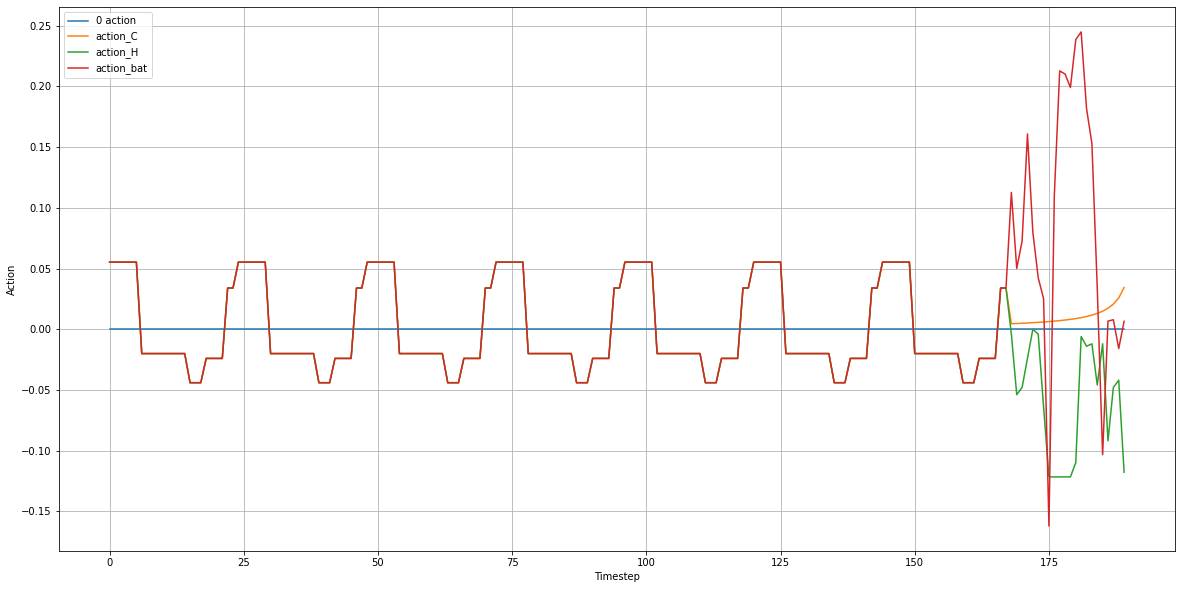

In [425]:
plt.figure(figsize=(20,10))
list_actions = ['action_C', 'action_H', 'action_bat']

plt.plot([0]*len(bd_actions), label="0 action")

for i, actions in enumerate(np.array(bd_actions).T):
    plt.plot(actions, label=list_actions[i])
plt.legend()
plt.grid()
plt.xlabel("Timestep")
plt.ylabel("Action")
plt.show()

In [342]:
#optimization debug -> !!! PROBLEM !!!
debug = get_actions(data_est, 5, debug=True, apply_seed=False)
debug[0].solve()

'Unbounded Solution'

In [332]:
pd.DataFrame([*data_est['c_Csto_end'], *data_est['c_Hsto_end'], *data_est['c_bat_end']], index=[
    "c_Csto_start", "c_Csto_end", "c_Hsto_start", "c_Hsto_end", "c_bat_start", "c_bat_end"
])

,0,1,2,3,4,5,6,7,8
c_Csto_start,1.000000,0.998292,0.998396,0.998235,0.998748,1.0,1.0,0.998897,0.999506
c_Csto_end,0.100000,0.100000,0.100000,0.100000,0.100000,0.1,0.1,0.100000,0.100000
c_Hsto_start,1.000000,1.000000,0.000000,0.000000,1.000000,1.0,1.0,0.882952,1.000000
c_Hsto_end,0.100000,0.100000,0.100000,0.100000,0.100000,0.1,0.1,0.100000,0.100000
c_bat_start,0.582747,0.004301,0.360446,0.609623,0.000000,0.0,0.0,0.000000,0.000000
c_bat_end,0.100000,0.100000,0.100000,0.100000,0.100000,0.1,0.1,0.100000,0.100000


In [336]:
t_test = 4

bd_debug = []
row_ind = []
for key in data.keys():
    if len(data[key]) > 2:
        row_ind.append(key)
        bd_debug.append(data[key][t_test])
pd.DataFrame(bd_debug, index=row_ind)

,0,1,2,3,4,5,6,7,8
p_ele,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
E_grid_past,107.185799,107.185799,107.185799,107.185799,107.185799,107.185799,107.185799,107.185799,107.185799
E_ns,15.120000,6.430000,2.360000,0.440000,10.800000,12.800000,13.600000,10.600000,16.700000
H_bd,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.360000,0.240000,0.120000
C_bd,0.000000,0.000000,0.000000,0.000000,0.010000,0.780000,0.240000,0.000000,0.230000
E_pv,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
COP_C,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
E_hpC_max,3140.773537,643.208121,1757.303590,2181.332109,550.338254,564.727698,558.180298,426.869750,516.745186
eta_ehH,0.900000,0.920000,0.870000,0.900000,0.900000,0.850000,0.900000,0.930000,0.900000
E_ehH_max,5.340000,16.450000,0.000000,0.000000,40.080000,35.040000,42.720000,37.320000,34.080000


In [ ]:
basic_agent_cost = env.cost()

In [ ]:
# Plotting 5 days of winter operation of year 1
plt.figure(figsize=(16,5))
interval = range(0,24*5)
plt.plot(env.net_electric_consumption_no_pv_no_storage[interval])
plt.plot(env.net_electric_consumption_no_storage[interval])
plt.plot(env.net_electric_consumption[interval], '--')
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Electricity demand without storage or generation (kW)', 'Electricity demand with PV generation and without storage(kW)', 'Electricity demand with PV generation and using RBC for storage(kW)'])

In [ ]:
# total_rewards = np.array(total_rewards).T
# plt.figure(figsize=(15, 10))
# for i in range(9):
#     plt.plot(total_rewards[i], label='Building_'+str(i))

# plt.xlabel('Hour')
# plt.ylabel('Reward')
# plt.legend()
# plt.show()
# print(total_rewards.sum(1)) #total reward per building